In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split

In [2]:
def RandomIntList(start, stop, number): #生成随机数列表
    start, stop = (int(start), int(stop)) if start <= stop else (int(stop), int(start))
    number = int(abs(number)) if number else 0
    random_list = []
    for i in range(number):
        random_list.append(random.randint(start, stop))
    return random_list

In [3]:
#松弛变量为max(0,1-y(wx-b))
def HingeLoss(X,y,w):
    n_sample = X.shape[0]
    f1 = np.ones((n_sample,1)) - y * np.dot(X,w)
    #f_sum = 0
    for i in range (n_sample):
        if(f1[i,0] < 0):
            f1[i,0] = 0
    return f1 #返回值为记录松弛变量的列向量

In [4]:
#损失函数为 【((w.T)w)/2 + c * Hingeloss】/n
def Loss(X,y,w):
    c = 0.9
    n_sample,n_feature = X.shape
    loss = np.dot(w.T,w)/2 + c * np.sum(HingeLoss(X,y,w))
    loss = loss/n_sample
    return (loss[0,0])

In [5]:
def Gradient(X,y,w):
    c = 0.9
    n_sample,n_feature = X.shape
    f1 = np.ones((n_sample,1)) - y * np.dot(X,w)  # 1-y(Xw+b) ,用来判断下一步的梯度
    gradient = np.zeros((1,n_feature))
    for i in range (n_sample):
        if(f1[i,0] < 0):
            gradient = gradient + w.T;  # (1-y(Xw+b)) < 0,梯度为 w.T
        else:
            gradient = gradient + w.T - c * y[i] * X[i] # (1-y(Xw+b)) >= 0,梯度为 w.T -c*((y.T)X)
    return (gradient/n_sample)   #返回的梯度为行向量

In [6]:
def RMSProp(X_train,y_train,X_test,y_test,iteration,batchSize,random_list,test_loss):
    n_sample,n_feature = X_train.shape
    w = np.zeros((n_feature,1))
    lr = 0.001
    t = 0.9 #伽马
    G = np.zeros((n_feature,1))
    c = np.power(10.0,-8)
    for i in range(iteration):
        #用随机数列表构造批量数据的矩阵，用来计算批量梯度
        X_batch = np.array([X_train[j] for j in (random_list[i])],dtype = int).reshape(batchSize,n_feature)
        y_batch = np.array([y_train[j] for j in (random_list[i])],dtype = int).reshape(batchSize,1)  
        grad = Gradient(X_batch,y_batch,w).T
        G = t * G + (1-t)*(grad*grad)
        w = w - (lr / np.sqrt(G + c) * grad)
        test_loss.append(Loss(X_test,y_test,w))
    return w

In [7]:
def AdaDelta(X_train,y_train,X_test,y_test,iteration,batchSize,random_list,test_loss):
    n_sample,n_feature = X_train.shape
    w = np.zeros((n_feature,1))
    gamma = 0.95
    delta_t = np.zeros((n_feature,1))
    c = np.power(10.0,-8)
    G = np.zeros((n_feature,1))
    for i in range(iteration):
         #用随机数列表构造批量数据的矩阵，用来计算批量梯度
        X_batch = np.array([X_train[j] for j in (random_list[i])],dtype = int).reshape(batchSize,n_feature)
        y_batch = np.array([y_train[j] for j in (random_list[i])],dtype = int).reshape(batchSize,1)  
        grad = Gradient(X_batch,y_batch,w).T
        G = gamma * G + (1-gamma) * grad * grad
        delta_w = - (np.sqrt(delta_t + c)/np.sqrt(G + c)) * grad
        w = w + delta_w
        delta_t = gamma * delta_t + (1 - gamma) * delta_w * delta_w
        test_loss.append(Loss(X_test,y_test,w))
    return w

In [8]:
def Adam(X_train,y_train,X_test,y_test,iteration,batchSize,random_list,test_loss):
    w = np.zeros((X_test.shape[1],1))
    gamma = 0.999
    delta_t = np.zeros((X_train.shape[1],1))
    c = np.power(10.0,-8)
    G = np.zeros((X_train.shape[1],1))
    m = np.zeros((X_train.shape[1],1))
    beta = 0.9 #可能需要衰减
    lr = 0.001 #可能需要衰减
    
    for i in range(iteration):
         #用随机数列表构造批量数据的矩阵，用来计算批量梯度
        X_batch = np.array([X_train[j] for j in (random_list[i])],dtype = int).reshape(batchSize,n_feature)
        y_batch = np.array([y_train[j] for j in (random_list[i])],dtype = int).reshape(batchSize,1)  
        grad = Gradient(X_batch,y_batch,w).T
        m = beta * m + (1-beta) * grad
        G = gamma * G + (1 - gamma) * grad * grad
        alpha = lr * np.sqrt(1-np.power(gamma,iteration)) / (1-np.power(beta,iteration))
        w = w - alpha * m / np.sqrt(G + c)
        test_loss.append(Loss(X_test,y_test,w))
    return w

In [9]:
def NAG(X_train,y_train,X_test,y_test,iteration,batchSize,random_list,test_loss):
    w = np.zeros((X_train.shape[1],1))
    gamma = 0.9
    lr = 0.001
    v = np.zeros((X_train.shape[1],1))
    for i in range(iteration):
         #用随机数列表构造批量数据的矩阵，用来计算批量梯度
        X_batch = np.array([X_train[j] for j in (random_list[i])],dtype = int).reshape(batchSize,n_feature)
        y_batch = np.array([y_train[j] for j in (random_list[i])],dtype = int).reshape(batchSize,1)  
        gradient = Gradient(X_batch,y_batch,w-gamma * v).T
        v = gamma * v + lr * gradient
        w = w - v
        test_loss.append(Loss(X_test,y_test,w))
    return w

In [10]:
def Validation(X_train,y_train,X_test,y_test,w):
    n_test = X_test.shape[0]  #验证集数量
    result = np.dot(X_test,w) # 记录 (wx -b)

    hingeloss = HingeLoss(X_train,y_train,w) #计算松弛变量
    n = 0  #记录松弛变量>0的个数
    sum_hinge = 0 #记录松弛变量>0的松弛变量的和
    for i in range(X_train.shape[0]):
        if(hingeloss[i,0] > 0):
            n = n+1
            sum_hinge += hingeloss[i,0]
    hinge = sum_hinge/n   #松弛变量值的均值(为0的不参与平均） 
    for i in range(n_test):
        if(result[i] >(1-hinge)):
            result[i] = 1
        else:
            result[i] = -1

    n = 0
    for i in range(n_test):  #计算判断正确的个数
           if(result[i,0] == y_test[i,0]):
                n += 1

    right_rate = n/n_test #计算正确率
    return right_rate

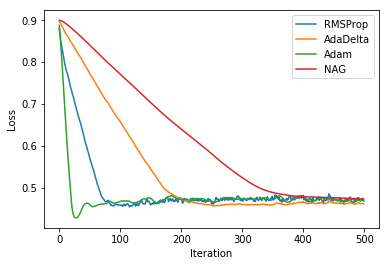

In [15]:
#这个是mini-batch SGD 的loss curve
data_train = load_svmlight_file("/home/wade/ML2017-lab-02/a9a.txt")
data_test = load_svmlight_file("/home/wade/ML2017-lab-02/a9a_t.txt")

X_train = data_train[0].toarray() #转为二维数组
X_train = np.c_[X_train,np.ones((X_train.shape[0],1))]  #加一行来计算常数项b
X_test = data_test[0].toarray() #转为二维数组
X_test = np.c_[X_test,np.zeros((X_test.shape[0],2))]  #稀疏矩阵被隐藏了全0的一列，再加一列计算常亮b
y_train = data_train[1].reshape(X_train.shape[0],1)   #转为列向量
y_test = data_test[1].reshape(X_test.shape[0],1)  #转为列向量


#w = np.zeros((X_test.shape[1],1))
n_train,n_feature = X_train.shape

#用来记录梯度下降过程中产生的loss
RMSProp_loss = []
AdaDelta_loss = []
Adam_loss = []
NAG_loss = []
iteration = 500 #迭代次数
batchSize = 100 #每次梯度下降用到的样本数
#生成随机数矩阵
random_list = np.random.randint(0, n_train-1,iteration * batchSize).reshape(iteration,batchSize)

w1 = RMSProp(X_train,y_train,X_test,y_test,iteration,batchSize,random_list,RMSProp_loss)
w2 = AdaDelta(X_train,y_train,X_test,y_test,iteration,batchSize,random_list,AdaDelta_loss)
w3 = Adam(X_train,y_train,X_test,y_test,iteration,batchSize,random_list,Adam_loss)
w4 = NAG(X_train,y_train,X_test,y_test,iteration,batchSize,random_list,NAG_loss)

plt.plot(range(iteration),RMSProp_loss,label='RMSProp')
plt.plot(range(iteration),AdaDelta_loss,label='AdaDelta')
plt.plot(range(iteration),Adam_loss,label ="Adam")
plt.plot(range(iteration),NAG_loss,label ="NAG")
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

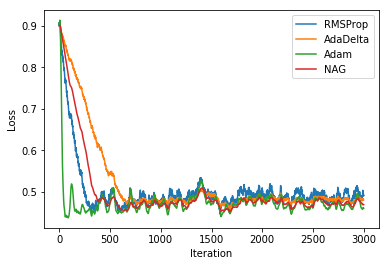

In [11]:
#这个是SGD的的loss curve
data_train = load_svmlight_file("/home/wade/ML2017-lab-02/a9a.txt")
data_test = load_svmlight_file("/home/wade/ML2017-lab-02/a9a_t.txt")

X_train = data_train[0].toarray() #转为二维数组
X_train = np.c_[X_train,np.ones((X_train.shape[0],1))]  #加一行来计算常数项b
X_test = data_test[0].toarray() #转为二维数组
X_test = np.c_[X_test,np.zeros((X_test.shape[0],2))]  #稀疏矩阵被隐藏了全0的一列，再加一列计算常亮b
y_train = data_train[1].reshape(X_train.shape[0],1)   #转为列向量
y_test = data_test[1].reshape(X_test.shape[0],1)  #转为列向量

#w = np.zeros((X_test.shape[1],1))
n_train,n_feature = X_train.shape
RMSProp_loss = []
AdaDelta_loss = []
Adam_loss = []
NAG_loss = []
iteration = 3000 #迭代次数 
batchSize = 1 #每次梯度下降用到的样本数
#生成随机数矩阵
random_list = np.random.randint(0, n_train-1,iteration * batchSize).reshape(iteration,batchSize)

w1 = RMSProp(X_train,y_train,X_test,y_test,iteration,batchSize,random_list,RMSProp_loss)
w2 = AdaDelta(X_train,y_train,X_test,y_test,iteration,batchSize,random_list,AdaDelta_loss)
w3 = Adam(X_train,y_train,X_test,y_test,iteration,batchSize,random_list,Adam_loss)
w4 = NAG(X_train,y_train,X_test,y_test,iteration,batchSize,random_list,NAG_loss)

plt.plot(range(iteration),RMSProp_loss,label='RMSProp')
plt.plot(range(iteration),AdaDelta_loss,label='AdaDelta')
plt.plot(range(iteration),Adam_loss,label ="Adam")
plt.plot(range(iteration),NAG_loss,label ="NAG")
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()